<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S8-Assignment/EVA_S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**cloning the models git hub **

In [1]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 15.2 MB/s 
     |████████████████████████████████| 47.6 MB 1.7 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
!git clone https://github.com/peeyushsinghal/common-pytorch-models.git

Cloning into 'common-pytorch-models'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 75 (delta 29), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [3]:
# !cd common-pytorch-models/
# # import os
# # os.getcwd() 

In [4]:
import os
os.getcwd() 
os.chdir('common-pytorch-models')

#### Setting Device and Seed

In [5]:
# loading helper functions
from utils.helper import seed_all, get_device, get_mean_std_dev

In [6]:
# check for default device

device = get_device()
print (f' device Status : {device}')
device

 device Status : cuda


device(type='cuda')

In [7]:
## setting seed for reproducibility
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
seed_all(SEED)

### Loading data

In [8]:
# Getting Mean and Standard Deviation of CIFAR 10 dataset
mean, std_dev = get_mean_std_dev("CIFAR10")
print(f"Mean : {mean}   STD: {std_dev}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Mean : (0.4913996786152028, 0.4821584083946074, 0.4465309144454644)   STD: (0.24703223246328238, 0.2434851280000556, 0.26158784172796423)


### Applying Transformations

In [9]:
from utils.transforms import apply_transforms_resnet

train_transforms, test_transforms = apply_transforms_resnet(mean,std_dev)

### Train and Test data

In [10]:
from torchvision import datasets

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 **Labels**

In [11]:
labels = trainset.classes
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

 **Train and Test set Dataloader**

In [12]:
import torch
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#### Visualizing Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

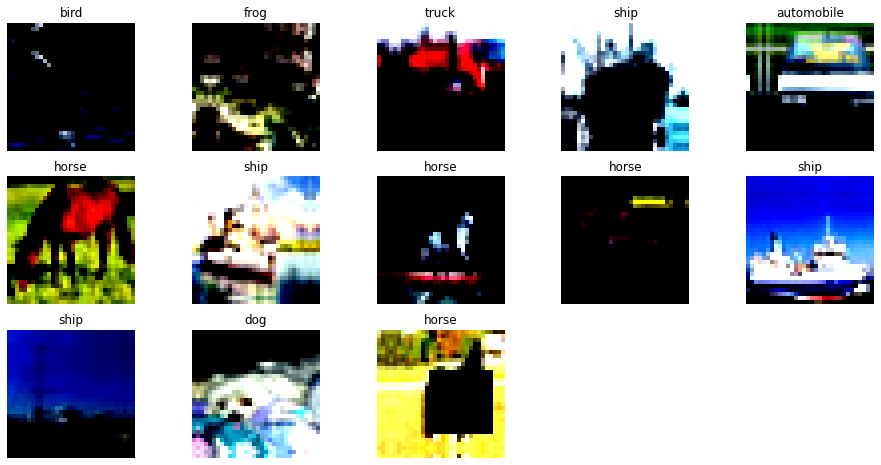

In [13]:
from utils.plot_utils import show_batch
show_batch(trainloader,labels,num_images=13) # for visualizing images

### 2. Network
Loading Model, understanding model params by checking summary

In [14]:
from models.resnet import ResNet18 # Model
from utils.helper import model_summary # shows summary 

model = ResNet18("LN").to(device) # creating model
model_summary(model, (3, 32, 32)) # shows model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
        GroupNorm-14          [-1, 128,

### 3. Training and Testing

*   includes test and train functions
*   includes loop function, where test can happen after each epoch is trained

In [15]:
import torch.optim as optim # for optimizer
import torch.nn as nn # for network, criterion
import torch.nn.functional as F 


criterion = nn.CrossEntropyLoss()

epochs = 40
# epochs = 1
lr = 0.001



# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
                                                 factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')

In [16]:
from main import trainer, train, test # including wrapper function of train and test
train_accuracy, train_losses, test_accuracy, test_losses = trainer(model,device, trainloader, testloader, optimizer,epochs,criterion,scheduler)


EPOCH: 1


Loss=1.8304235935211182 Batch_id=390 Accuracy=21.75: 100%|██████████| 391/391 [04:37<00:00,  1.41it/s]



Test set: Average loss: 0.0002, Accuracy: 3818/10000 (38.18%)

EPOCH: 2


Loss=1.3948700428009033 Batch_id=390 Accuracy=39.20: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0002, Accuracy: 4949/10000 (49.49%)

EPOCH: 3


Loss=1.2469741106033325 Batch_id=390 Accuracy=48.60: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 5695/10000 (56.95%)

EPOCH: 4


Loss=0.9034155011177063 Batch_id=390 Accuracy=56.11: 100%|██████████| 391/391 [04:40<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 6007/10000 (60.07%)

EPOCH: 5


Loss=1.1485493183135986 Batch_id=390 Accuracy=60.81: 100%|██████████| 391/391 [04:40<00:00,  1.39it/s]



Test set: Average loss: 0.0001, Accuracy: 6677/10000 (66.77%)

EPOCH: 6


Loss=1.1338074207305908 Batch_id=390 Accuracy=64.33: 100%|██████████| 391/391 [04:40<00:00,  1.39it/s]



Test set: Average loss: 0.0001, Accuracy: 6939/10000 (69.39%)

EPOCH: 7


Loss=0.6876113414764404 Batch_id=390 Accuracy=67.55: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 7140/10000 (71.40%)

EPOCH: 8


Loss=0.6268678307533264 Batch_id=390 Accuracy=69.96: 100%|██████████| 391/391 [04:40<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 7486/10000 (74.86%)

EPOCH: 9


Loss=0.7031857967376709 Batch_id=390 Accuracy=72.51: 100%|██████████| 391/391 [04:40<00:00,  1.39it/s]



Test set: Average loss: 0.0001, Accuracy: 7631/10000 (76.31%)

EPOCH: 10


Loss=0.8108428120613098 Batch_id=390 Accuracy=74.62: 100%|██████████| 391/391 [04:40<00:00,  1.39it/s]



Test set: Average loss: 0.0001, Accuracy: 7916/10000 (79.16%)

EPOCH: 11


Loss=0.7271196246147156 Batch_id=390 Accuracy=76.56: 100%|██████████| 391/391 [04:40<00:00,  1.39it/s]



Test set: Average loss: 0.0000, Accuracy: 7963/10000 (79.63%)

EPOCH: 12


Loss=0.8341377377510071 Batch_id=390 Accuracy=77.71: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0000, Accuracy: 7945/10000 (79.45%)

EPOCH: 13


Loss=0.7017525434494019 Batch_id=390 Accuracy=79.28: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0000, Accuracy: 8075/10000 (80.75%)

EPOCH: 14


Loss=0.6111430525779724 Batch_id=390 Accuracy=80.65: 100%|██████████| 391/391 [04:40<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8412/10000 (84.12%)

EPOCH: 15


Loss=0.5561884045600891 Batch_id=390 Accuracy=81.69: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8289/10000 (82.89%)

EPOCH: 16


Loss=0.3301572799682617 Batch_id=390 Accuracy=82.46: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0000, Accuracy: 8432/10000 (84.32%)

EPOCH: 17


Loss=0.5815488696098328 Batch_id=390 Accuracy=83.55: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0000, Accuracy: 8315/10000 (83.15%)

EPOCH: 18


Loss=0.3074244558811188 Batch_id=390 Accuracy=84.39: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8476/10000 (84.76%)

EPOCH: 19


Loss=0.46510282158851624 Batch_id=390 Accuracy=85.41: 100%|██████████| 391/391 [04:40<00:00,  1.39it/s]



Test set: Average loss: 0.0000, Accuracy: 8580/10000 (85.80%)

EPOCH: 20


Loss=0.4870660901069641 Batch_id=390 Accuracy=86.12: 100%|██████████| 391/391 [04:40<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8660/10000 (86.60%)

EPOCH: 21


Loss=0.42867136001586914 Batch_id=390 Accuracy=86.78: 100%|██████████| 391/391 [04:40<00:00,  1.39it/s]



Test set: Average loss: 0.0000, Accuracy: 8703/10000 (87.03%)

EPOCH: 22


Loss=0.2912142872810364 Batch_id=390 Accuracy=87.19: 100%|██████████| 391/391 [04:40<00:00,  1.40it/s]



Test set: Average loss: 0.0000, Accuracy: 8655/10000 (86.55%)

EPOCH: 23


Loss=0.24988237023353577 Batch_id=390 Accuracy=87.84: 100%|██████████| 391/391 [04:40<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8690/10000 (86.90%)

EPOCH: 24


Loss=0.4671902656555176 Batch_id=390 Accuracy=88.60: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8567/10000 (85.67%)

EPOCH: 25


Loss=0.24809162318706512 Batch_id=390 Accuracy=89.18: 100%|██████████| 391/391 [04:40<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8770/10000 (87.70%)

EPOCH: 26


Loss=0.27786386013031006 Batch_id=390 Accuracy=89.61: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8796/10000 (87.96%)

EPOCH: 27


Loss=0.23959887027740479 Batch_id=390 Accuracy=90.09: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8835/10000 (88.35%)

EPOCH: 28


Loss=0.31698065996170044 Batch_id=390 Accuracy=90.41: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0000, Accuracy: 8780/10000 (87.80%)

EPOCH: 29


Loss=0.30408746004104614 Batch_id=390 Accuracy=90.91: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0000, Accuracy: 8885/10000 (88.85%)

EPOCH: 30


Loss=0.252580463886261 Batch_id=390 Accuracy=91.26: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8874/10000 (88.74%)

EPOCH: 31


Loss=0.21087530255317688 Batch_id=390 Accuracy=91.82: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8828/10000 (88.28%)

EPOCH: 32


Loss=0.18724502623081207 Batch_id=390 Accuracy=91.77: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8894/10000 (88.94%)

EPOCH: 33


Loss=0.30262133479118347 Batch_id=390 Accuracy=92.38: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8910/10000 (89.10%)

EPOCH: 34


Loss=0.27009814977645874 Batch_id=390 Accuracy=92.84: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8879/10000 (88.79%)

EPOCH: 35


Loss=0.22618761658668518 Batch_id=390 Accuracy=92.78: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 9016/10000 (90.16%)

EPOCH: 36


Loss=0.2472740113735199 Batch_id=390 Accuracy=93.19: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8898/10000 (88.98%)

EPOCH: 37


Loss=0.1831251084804535 Batch_id=390 Accuracy=93.42: 100%|██████████| 391/391 [04:37<00:00,  1.41it/s]



Test set: Average loss: 0.0001, Accuracy: 9034/10000 (90.34%)

EPOCH: 38


Loss=0.19914939999580383 Batch_id=390 Accuracy=93.79: 100%|██████████| 391/391 [04:38<00:00,  1.41it/s]



Test set: Average loss: 0.0001, Accuracy: 8819/10000 (88.19%)

EPOCH: 39


Loss=0.26021361351013184 Batch_id=390 Accuracy=93.81: 100%|██████████| 391/391 [04:38<00:00,  1.40it/s]



Test set: Average loss: 0.0001, Accuracy: 8850/10000 (88.50%)

EPOCH: 40


Loss=0.11767563968896866 Batch_id=390 Accuracy=93.88: 100%|██████████| 391/391 [04:37<00:00,  1.41it/s]



Test set: Average loss: 0.0001, Accuracy: 8989/10000 (89.89%)



### 4. Checking results
visualizing train_accuracy, train_losses, test_accuracy, test_losses

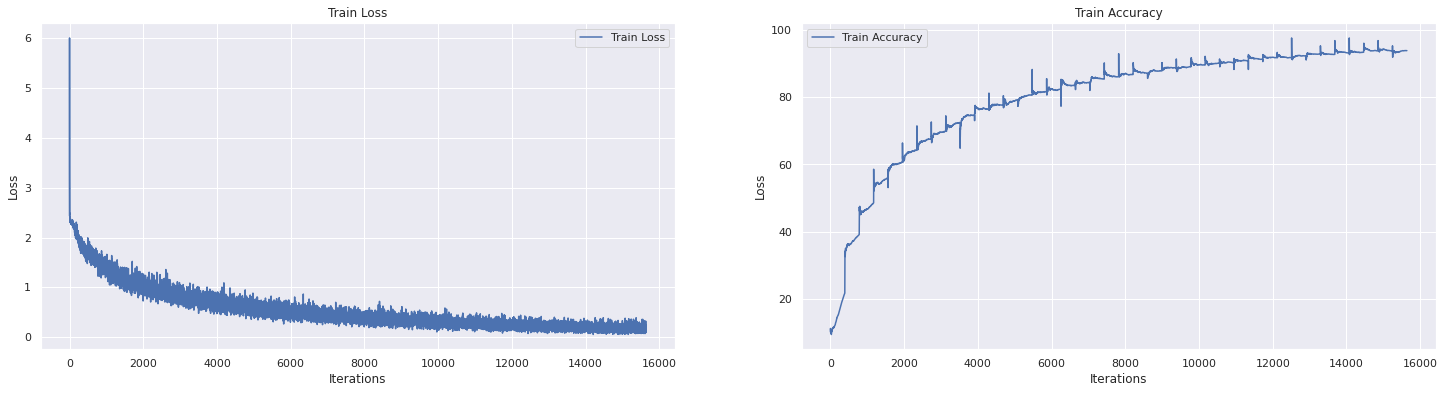

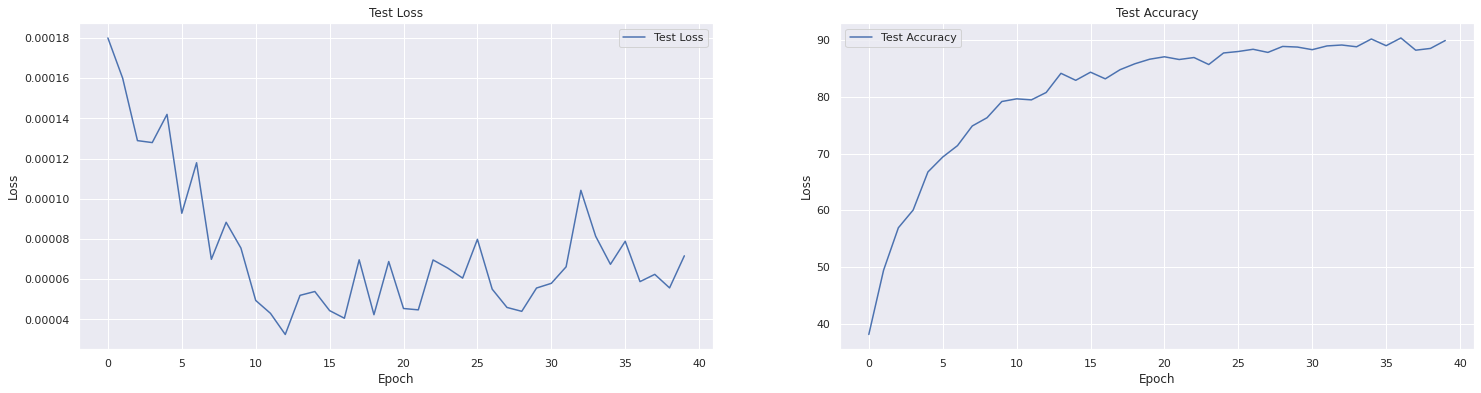

In [17]:
from utils.plot_utils import plot_metrics

plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

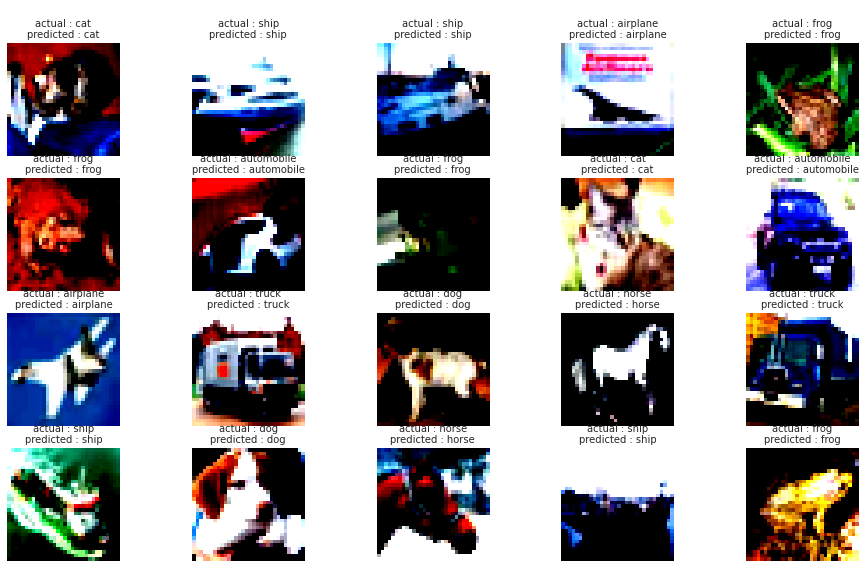

In [18]:
# import matplotlib.pyplot as plt

# def show_predicted_actual(model, device, dataset_loader, label_names,num_images=10):
# 	'''
# 	shows a batch of predicted and actual images (default=10 )
# 	'''
# 	images, targets = next(iter(dataset_loader))
# 	images = images.to(device)
# 	outputs = model(images)
# 	_, predicted = torch.max(outputs, 1)

# 	plt.figure(figsize=(16, 12))
# 	for i in range(num_images):
# 		ax = plt.subplot(int(num_images//5)+1, 5, i + 1)
# 		ax.imshow(images[i].cpu().permute(1, 2, 0))
# 		ax.set_title(f"\nactual : {label_names[targets[i]]}\npredicted : {label_names[predicted[i]]}", fontsize=10)

# 		# plt.title("actual:"+label_names[targets[i]])
# 		plt.axis("off")

from utils.plot_utils import show_predicted_actual

show_predicted_actual(model, device, testloader, labels,num_images=20)

### Misclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 1011


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


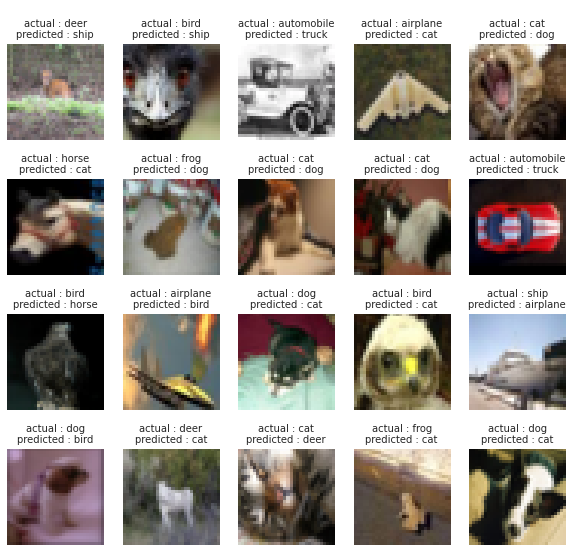

In [19]:
from utils.plot_utils import misclassified_images

images_misclassified = misclassified_images(model, testloader, device, mean, std_dev)

In [ ]:
# def evaluate_classwise_accuracy(model, device, classes, test_loader):
#     class_correct = list(0. for i in range(10))
#     class_total = list(0. for i in range(10))
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             c = (predicted == labels).squeeze()
#             for i in range(4):
#             	label = labels[i]
#             	class_correct[label] += c[i].item()
#             	class_total[label] += 1

#     for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * class_correct[i] / class_total[i]))
      
# evaluate_classwise_accuracy(model, device, labels, testloader)


*Class Level Accuarcy*

In [ ]:
## Checking class level accuracy
from utils.helper import evaluate_classwise_accuracy
evaluate_classwise_accuracy(model, device, labels, testloader)


### Grad Cam output for 20 misclassified images

first top 10 images are shown
then next 10 images are shown

In [ ]:
from utils.grad_cam import generate_gradcam, plot_gradcam

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[:10], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 32, 32), predicted_classes, images_misclassified[:10])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Generating Grad-CAM for layer1
Generating Grad-CAM for layer2
Generating Grad-CAM for layer3
Generating Grad-CAM for layer4


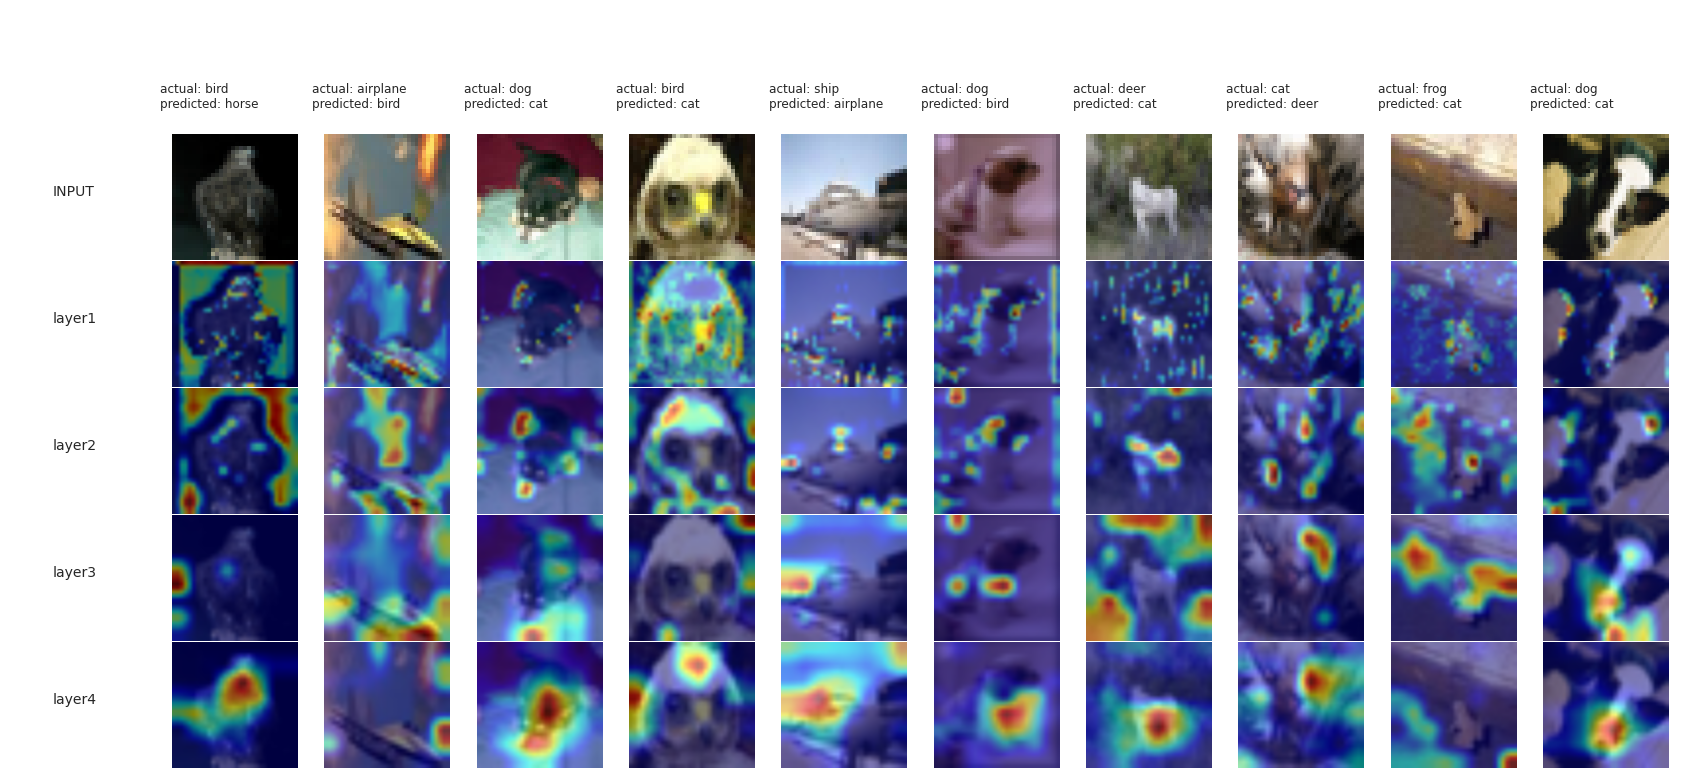

In [23]:
from utils.grad_cam import generate_gradcam, plot_gradcam

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[10:20], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 32, 32), predicted_classes, images_misclassified[10:20])